In [10]:
import lbforaging
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

from games.foraging import Foraging
from agents.iql_agent import IQLAgent, IQLAgentConfig
from agents.jal_am_agent import JALAgent, JALAgentConfig

In [11]:
game_config = [
        "Foraging-5x5-2p-1f-v3",
        "Foraging-8x8-2p-1f-v3",
        "Foraging-8x8-3p-1f-v3",
        "Foraging-8x8-3p-1f-coop-v3",
    ]

In [12]:
# Configuración mixta
mixed_config = {
    'game': game_config[0],  # Foraging-5x5-2p-1f-v3
    'iql': IQLAgentConfig(alpha=0.1, min_epsilon=0.01, max_t=10000, seed=1),
    'jal': JALAgentConfig(alpha=0.1, min_epsilon=0.05, epsilon_decay=0.99999, max_t=10000, seed=1),
    'train_config': {
        'episodes': 100,
        'iterations': 50,
    },
    'agent_types': {
        'agent_0': 'jal',  # Primer agente usa JAL
        'agent_1': 'jal'   # Segundo agente usa IQL
    }
}


coop_config = {
    'game': game_config[3],  # Foraging-8x8-3p-1f-coop-v3
    'iql': IQLAgentConfig(alpha=0.1, min_epsilon=0.01, max_t=10000, seed=1),
    'jal': JALAgentConfig(alpha=0.1, min_epsilon=0.05, epsilon_decay=0.99999, max_t=10000, seed=1),
    'train_config': {
        'episodes': 100,
        'iterations': 50,
    },
    'agent_types': {
        'agent_0': 'jal',  # Primer agente usa JAL
        'agent_1': 'jal',   # Segundo agente usa JAL
        'agent_2': 'jal'   # Tercer agente usa JAL
    }
}


In [13]:
# Crear el juego
game = Foraging(config=coop_config['game'], seed=1)

# Crear agentes mixtos
agents = {}
for agent_id in game.agents:
    if mixed_config['agent_types'].get(agent_id, 'iql') == 'jal':
        agents[agent_id] = JALAgent(game, agent_id, coop_config['jal'])
    else:
        agents[agent_id] = IQLAgent(game, agent_id, coop_config['iql'])

/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [14]:
game.reset()
for agent in game.agents:
    print(f"Agent: {agent}")
    print(f"Observation: {game.observe(agent)}")

Agent: agent_0
Observation: [5. 2. 4. 0. 1. 2. 7. 1. 1. 6. 3. 1.]
Agent: agent_1
Observation: [5. 2. 4. 7. 1. 1. 0. 1. 2. 6. 3. 1.]
Agent: agent_2
Observation: [5. 2. 4. 6. 3. 1. 0. 1. 2. 7. 1. 1.]


In [15]:
def play_episode(game, agents, verbose=False, render=False):

    # Initialize the game
    game.reset()
    step_count = 0

    # Initialize each agent
    for agent in game.agents:
        agents[agent].reset()

    # Print initial observations if verbose is enabled
    if verbose:
        print(f"Step: {step_count}")
        for agent in game.agents:
            print(f"Agent {agent} observe: {game.observe(agent)}")

    # Initialize rewards for each agent
    cum_rewards = dict(map(lambda agent: (agent, 0.0), game.agents))

    # render the game if required
    if render:
        game.render()
        time.sleep(0.5)

    while not game.done():

        step_count += 1
        
        # Get actions from each agent
        actions = {}
        for agent in game.agents:
            actions[agent] = agents[agent].action()
             
        # Perform the actions in the game
        game.step(actions)

        # Update the cum_rewards for each agent
        for agent in game.agents:
            cum_rewards[agent] += game.reward(agent)

        # Print actions, rewards and next state if verbose is enabled
        if verbose:
            print(f"Step: {step_count}")
            for agent in game.agents:
                    print(f"Agent {agent} action: {actions[agent]} - {game.action_set[actions[agent]]}")
                    print(f"Agent {agent} reward: {game.reward(agent)}")
                    print(f"Agent {agent} observe: {game.observe(agent)}")
            
        if render:
            game.render()
            time.sleep(0.5)
    
        for agent in game.agents:
            # Update the agent with the last observation
            agents[agent].update()
    
    return cum_rewards

In [16]:
def run(game, agents, episodes=1, verbose=False, render=False):
    sum_rewards = dict(map(lambda agent: (agent, 0.0), game.agents))
    for _ in range(episodes):
        episode_start = time.time()
        cum_rewards = play_episode(game, agents, verbose=verbose, render=render)  
        for agent in game.agents:
            sum_rewards[agent] += cum_rewards[agent]
    if verbose:
        print(f"Average rewards over {episodes} episodes:")
        for agent in game.agents:
            print(f"Agent {agent}: {sum_rewards[agent] / episodes}")  
    return sum_rewards     

In [17]:
def train(game, agents, train_config, progress=False, verbose=False, render=False):
    iterations = train_config["iterations"]
    episodes = train_config["episodes"]
    total_episodes = iterations * episodes
    
    # Estadísticas de entrenamiento
    stats = {
        'average_rewards': {agent: [] for agent in game.agents},
        'episode_rewards': {agent: [] for agent in game.agents},
        'exploration_rates': {agent: [] for agent in game.agents},
        'time_per_episode': [],
        'total_time': 0
    }
    
    print(f"🚀 Starting training for {iterations} iterations ({total_episodes} total episodes)")
    start_time = time.time()
    
    # Configurar barra de progreso principal
    pbar = tqdm(total=total_episodes, desc="Training Progress", unit="episode", disable=not progress)
    
    for i in range(1, iterations + 1):
        iteration_rewards = {agent: 0.0 for agent in game.agents}
        iteration_exploration = {agent: 0.0 for agent in game.agents}
        
        for e in range(1, episodes + 1):
            episode_start = time.time()
            episode_num = (i - 1) * episodes + e
            
            # Ejecutar episodio
            cum_rewards = play_episode(game, agents, verbose=verbose, render=render)
            
            # Calcular tiempo del episodio
            episode_time = time.time() - episode_start
            stats['time_per_episode'].append(episode_time)
            
            # Actualizar estadísticas
            for agent in game.agents:
                iteration_rewards[agent] += cum_rewards[agent]
                stats['episode_rewards'][agent].append(cum_rewards[agent])
                
                # Registrar exploración (para agentes que la tengan)
                if hasattr(agents[agent], 'config') and hasattr(agents[agent].config, 'initial_epsilon'):
                    iteration_exploration[agent] += agents[agent].config.initial_epsilon
            
            # Actualizar barra de progreso
            pbar.set_postfix({
                'Iter': f"{i}/{iterations}",
                'Last Rewards': {a: f"{r:.1f}" for a, r in cum_rewards.items()},
                'Time/ep': f"{episode_time:.2f}s"
            })
            pbar.update(1)
        
        # Guardar promedios por iteración
        for agent in game.agents:
            stats['average_rewards'][agent].append(iteration_rewards[agent] / episodes)
            stats['exploration_rates'][agent].append(iteration_exploration[agent] / episodes)
    
    # Finalizar medición de tiempo
    stats['total_time'] = time.time() - start_time
    pbar.close()
    
    # Mostrar resumen final
    if progress:
        print(f"\n✅ Training completed in {stats['total_time']:.2f} seconds")
        print(f"⏱️ Average time per episode: {np.mean(stats['time_per_episode']):.2f}s")
        
        print("\n🏆 Final Performance:")
        for agent in game.agents:
            agent_type = type(agents[agent]).__name__
            final_avg = np.mean(stats['average_rewards'][agent][-5:])  # Últimas 5 iteraciones
            best_episode = np.max(stats['episode_rewards'][agent])
            
            print(f"\nAgent {agent} ({agent_type}):")
            print(f"  • Final Avg Reward: {final_avg:.2f}")
            print(f"  • Best Episode Reward: {best_episode:.2f}")
            print(f"  • Final Exploration: {stats['exploration_rates'][agent][-1]:.3f}")
    
    return stats

In [18]:

average_rewards = train(game, agents, train_config=mixed_config['train_config'], progress=True)


🚀 Starting training for 50 iterations (5000 total episodes)


Training Progress:   0%|          | 0/5000 [00:00<?, ?episode/s]

/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(
Training Progress: 100%|██████████| 5000/5000 [04:35<00:00, 18.15episode/s, Iter=50/50, Last Rewards={'agent_0': '0.0', 'agent_1': '0.0', 'agent_2': '0.0'}, Time/ep=0.07s]


✅ Training completed in 275.48 seconds
⏱️ Average time per episode: 0.05s

🏆 Final Performance:

Agent agent_0 (JALAgent):
  • Final Avg Reward: 0.00
  • Best Episode Reward: 0.00
  • Final Exploration: 0.050

Agent agent_1 (JALAgent):
  • Final Avg Reward: 0.00
  • Best Episode Reward: 0.00
  • Final Exploration: 0.050

Agent agent_2 (IQLAgent):
  • Final Avg Reward: 0.00
  • Best Episode Reward: 0.00
  • Final Exploration: 0.000


In [ ]:
q_table = agents[game.agents[0]].q_table
print(f"Q-table for agent {game.agents[0]}:")
print(f"Estados: {len(q_table.keys())}")

In [61]:
def plot_training_results(results, agents, game):
    """Función mejorada para visualizar los resultados del entrenamiento"""
    plt.figure(figsize=(15, 5))
    
    # Gráfico 1: Recompensas por episodio (suavizado)
    plt.subplot(1, 3, 1)
    for agent in game.agents:
        rewards = np.array(results['episode_rewards'][agent])
        
        # Suavizado para mejor visualización (media móvil de 10 episodios)
        window_size = max(10, len(rewards) // 20)
        smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        
        plt.plot(smoothed_rewards, 
                 label=f"{agent} ({type(agents[agent]).__name__})",
                 alpha=0.8,
                 linewidth=1.5)
    
    plt.xlabel('Episode (smoothed)')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode (Smoothed)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Gráfico 2: Recompensas promedio por iteración
    plt.subplot(1, 3, 2)
    for agent in game.agents:
        avg_rewards = results['average_rewards'][agent]
        plt.plot(avg_rewards, 
                 label=f"{agent} ({type(agents[agent]).__name__})",
                 linewidth=2,
                 marker='o',
                 markersize=4)
    
    plt.xlabel('Iteration')
    plt.ylabel('Average Reward')
    plt.title('Average Rewards per Iteration')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Gráfico 3: Evolución de la exploración
    plt.subplot(1, 3, 3)
    for agent in game.agents:
        if agent in results['exploration_rates']:
            plt.plot(results['exploration_rates'][agent],
                     label=f"{agent} Exploration",
                     linestyle='--',
                     alpha=0.7)
    
    plt.xlabel('Iteration')
    plt.ylabel('Exploration Rate')
    plt.title('Exploration Rate Evolution')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    
    # Guardar figura
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(f'training_results_{timestamp}.png', dpi=300)
    plt.show()

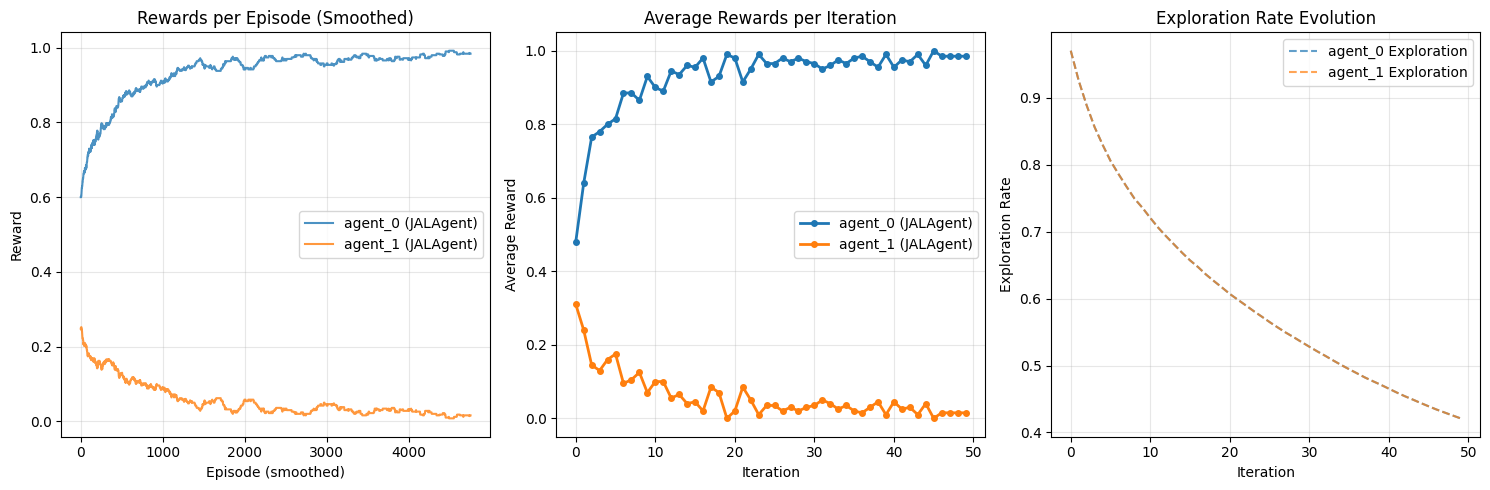

In [70]:
plot_training_results(average_rewards, agents, game)

TypeError: unhashable type: 'dict'

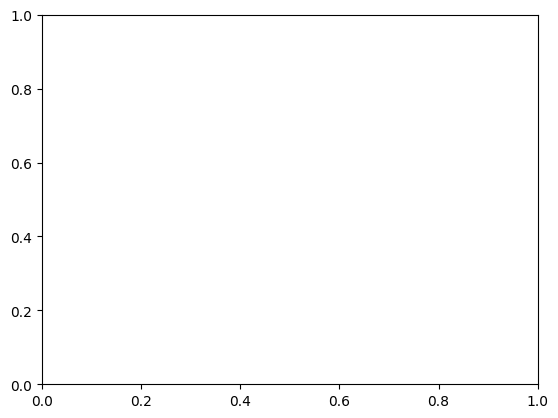

In [44]:
# Visualización
for agent, rewards in average_rewards.items():
    plt.plot(rewards, label=f"{agent} ({mixed_config['agent_types'].get(agent, 'iql')})")
plt.xlabel('Iterations')
plt.ylabel('Average Reward')
plt.title('Average Rewards: JAL vs IQL')
plt.legend()
plt.show()

In [71]:
for agent in game.agents:
    agents[agent].learn = False

In [72]:
run(game, agents, episodes=10, verbose=True, render=False)

Step: 0
Agent agent_0 observe: [3. 1. 2. 2. 3. 2. 0. 0. 2.]
Agent agent_1 observe: [3. 1. 2. 0. 0. 2. 2. 3. 2.]
Step: 1
Agent agent_0 action: 2 - SOUTH
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 3. 3. 2. 1. 0. 2.]
Agent agent_1 action: 2 - SOUTH
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 1. 0. 2. 3. 3. 2.]
Step: 2
Agent agent_0 action: 5 - LOAD
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 3. 3. 2. 1. 1. 2.]
Agent agent_1 action: 4 - EAST
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 1. 1. 2. 3. 3. 2.]
Step: 3
Agent agent_0 action: 3 - WEST
Agent agent_0 reward: 0
Agent agent_0 observe: [3. 1. 2. 3. 2. 2. 0. 1. 2.]
Agent agent_1 action: 1 - NORTH
Agent agent_1 reward: 0
Agent agent_1 observe: [3. 1. 2. 0. 1. 2. 3. 2. 2.]
Step: 4
Agent agent_0 action: 5 - LOAD
Agent agent_0 reward: 1.0
Agent agent_0 observe: [-1. -1.  0.  3.  2.  2.  0.  1.  2.]
Agent agent_1 action: 5 - LOAD
Agent agent_1 reward: 0
Agent agent_1 observe: [-1. -1.  0.  0

{'agent_0': 10.0, 'agent_1': 0.0}

In [73]:
def run_configuration(config):
    game = Foraging(config=config['game'], seed=config.get('seed', 1))
    
    agents = {}
    for agent_id in game.agents:
        agent_type = config['agent_types'].get(agent_id, 'iql')
        if agent_type == 'jal':
            agents[agent_id] = JALAgent(game, agent_id, config['jal'])
        else:
            agents[agent_id] = IQLAgent(game, agent_id, config['iql'])
    
    rewards = train(game, agents, config['train_config'], progress=True)
    
    # Visualización
    for agent, reward_history in rewards.items():
        plt.plot(reward_history, label=f"{agent} ({config['agent_types'].get(agent, 'iql')})")
    
    plt.title(f"Config: {config['game']}")
    plt.legend()
    plt.show()

/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Iteration 10 (1000 episodes)
Agent agent_0: 0.23
Agent agent_1: 0.36
Iteration 20 (2000 episodes)
Agent agent_0: 0.54
Agent agent_1: 0.44
Iteration 30 (3000 episodes)
Agent agent_0: 0.565
Agent agent_1: 0.435
Last average rewards over 30 iterations (3000 episodes):
Agent agent_0: 0.565
Agent agent_1: 0.435


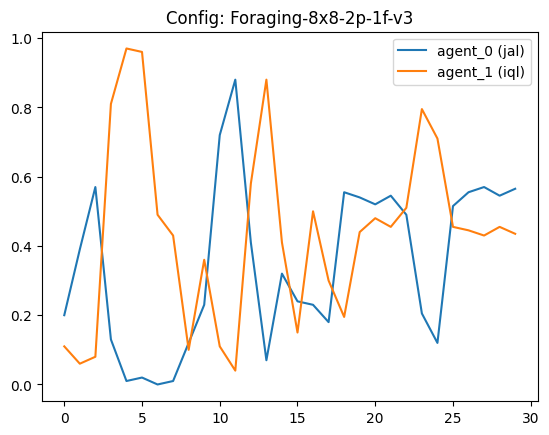

Iteration 10 (2000 episodes)
Agent agent_0: 0.11833333333333335
Agent agent_1: 0.06666666666666667
Agent agent_2: 0.065
Iteration 20 (4000 episodes)
Agent agent_0: 0.18500000000000003
Agent agent_1: 0.12749999999999997
Agent agent_2: 0.0775
Iteration 30 (6000 episodes)
Agent agent_0: 0.3949999999999999
Agent agent_1: 0.17999999999999994
Agent agent_2: 0.05
Last average rewards over 30 iterations (6000 episodes):
Agent agent_0: 0.3949999999999999
Agent agent_1: 0.17999999999999994
Agent agent_2: 0.05


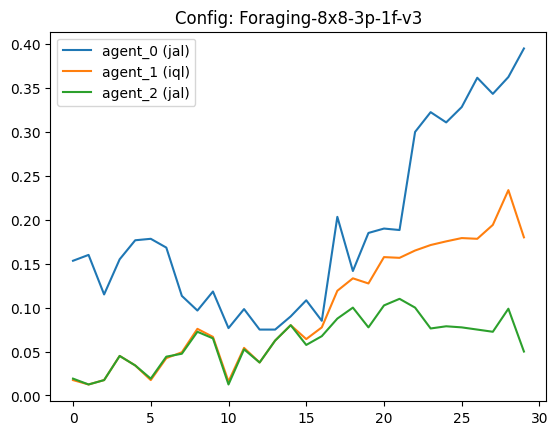

In [ ]:
# Ejemplo de configuraciones comparativas
configs = [
    {
        'game': "Foraging-8x8-2p-1f-v3",
        'iql': IQLAgentConfig(),
        'jal': JALAgentConfig(),
        'train_config': {'episodes': 100, 'iterations': 30},
        'agent_types': {'agent_0': 'jal', 'agent_1': 'jal'}
    },
    {
        'game': game_config[3],  # Foraging-8x8-3p-1f-coop-v3
        'iql': IQLAgentConfig(alpha=0.2),
        'train_config': {'episodes': 200, 'iterations': 30},
        'agent_types': {'agent_0': 'jal', 'agent_1': 'iql', 'agent_2': 'iql'}
    }
]

for config in configs:
    run_configuration(config)

/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Iteration 10 (2000 episodes)
Agent agent_0: 0.0
Agent agent_1: 0.0
Agent agent_2: 0.0
Iteration 20 (4000 episodes)
Agent agent_0: 0.0
Agent agent_1: 0.0
Agent agent_2: 0.0
Iteration 30 (6000 episodes)
Agent agent_0: 0.0
Agent agent_1: 0.0
Agent agent_2: 0.0
Last average rewards over 30 iterations (6000 episodes):
Agent agent_0: 0.0
Agent agent_1: 0.0
Agent agent_2: 0.0


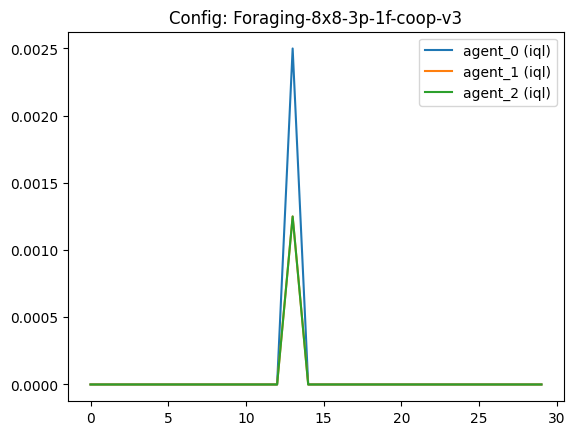

In [ ]:
iql_config = {
        'game': game_config[3],  # Foraging-8x8-3p-1f-coop-v3
        'iql': IQLAgentConfig(alpha=0.2),
        'train_config': {'episodes': 200, 'iterations': 30},
        'agent_types': {'agent_0': 'iql', 'agent_1': 'iql', 'agent_2': 'iql'}
    }
run_configuration(iql_config)